In [4]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random 
import os
import cv2

# Import the data

In [5]:
train_dir = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Train"
test_dir = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Test"
valid_dir = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Validation"
train_dir_augmented = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Train_augmented"

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = (144, 144),
                                                                shuffle = False) # don't shuffle test data for prediction analysis

test_data_1 = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = (128, 128),
                                                                shuffle = False) # don't shuffle test data for prediction analysis

Found 2030 files belonging to 7 classes.


Found 2030 files belonging to 7 classes.


In [6]:
class_names = test_data.class_names
class_names

['Atelectasis',
 'Effusion',
 'Infiltration',
 'Mass',
 'No_finding',
 'Nodule',
 'Pneumothorax']

In [7]:
#Creating a function to preprocess the images
def preprocess_img(image, label):
  """
  Converts image datatype from 'uint8' -> 'float32' and adds 2 copys of it 
  """
  image = tf.cast(image, tf.float32)
  return (tf.image.resize(image, [128,128]), tf.image.resize(image, [128,128]), image ), label 

In [8]:
# Map prepreprocessing function to test data
test_data = test_data.map(map_func = preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
test_data = test_data.prefetch(buffer_size = tf.data.AUTOTUNE)

test_data

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 144, 144, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

In [9]:
ensemble_model = tf.keras.models.load_model(r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\6_saved_models\ensemble_best_model.h5")

# Evaluating the model

## Confusion matrix

In [10]:
# Create test labels and predictions
test_labels = []
for images, labels in test_data.unbatch():
  test_labels.append(tf.argmax(labels).numpy())
test_pred_probs = ensemble_model.predict(test_data)
test_predictions = tf.argmax(test_pred_probs, axis=1)

64/64 [==============================] - 248s 4s/step


In [11]:
def plot_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), threshold=None, text_size=15):
    mc = confusion_matrix(y_true, y_pred)
    mc_norm = mc.astype('float') / mc.sum(axis=1)[:, np.newaxis]

    n_classes = mc.shape[0]

    fig, ax = plt.subplots(figsize=figsize)

    cax = ax.matshow(mc, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    if classes is None:
        classes = np.arange(n_classes)

    ax.set(
        title='Confusion Matrix',
        xlabel='Predicted Labels',
        ylabel='True Label',
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes)
    )
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes, rotation=45)

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    if threshold is None:
        threshold = (mc.max() + mc.min()) / 2

    for i, j in itertools.product(range(mc.shape[0]), range(mc.shape[1])):
        plt.text(j, i, f"{mc[i, j]} \n ({mc_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if mc[i, j] > threshold else "black",
                 size=text_size)

    return mc_norm

array([[0.5137931 , 0.0862069 , 0.02413793, 0.02068966, 0.22068966,
        0.06551724, 0.06896552],
       [0.11034483, 0.61034483, 0.06551724, 0.03793103, 0.05862069,
        0.02758621, 0.08965517],
       [0.13448276, 0.12068966, 0.13103448, 0.03103448, 0.34137931,
        0.14827586, 0.09310345],
       [0.1137931 , 0.12413793, 0.03103448, 0.33103448, 0.12758621,
        0.1862069 , 0.0862069 ],
       [0.11724138, 0.17241379, 0.05172414, 0.03448276, 0.37241379,
        0.16896552, 0.08275862],
       [0.07241379, 0.07586207, 0.03448276, 0.07931034, 0.39310345,
        0.25172414, 0.09310345],
       [0.07241379, 0.1       , 0.05517241, 0.03103448, 0.18275862,
        0.08965517, 0.46896552]])

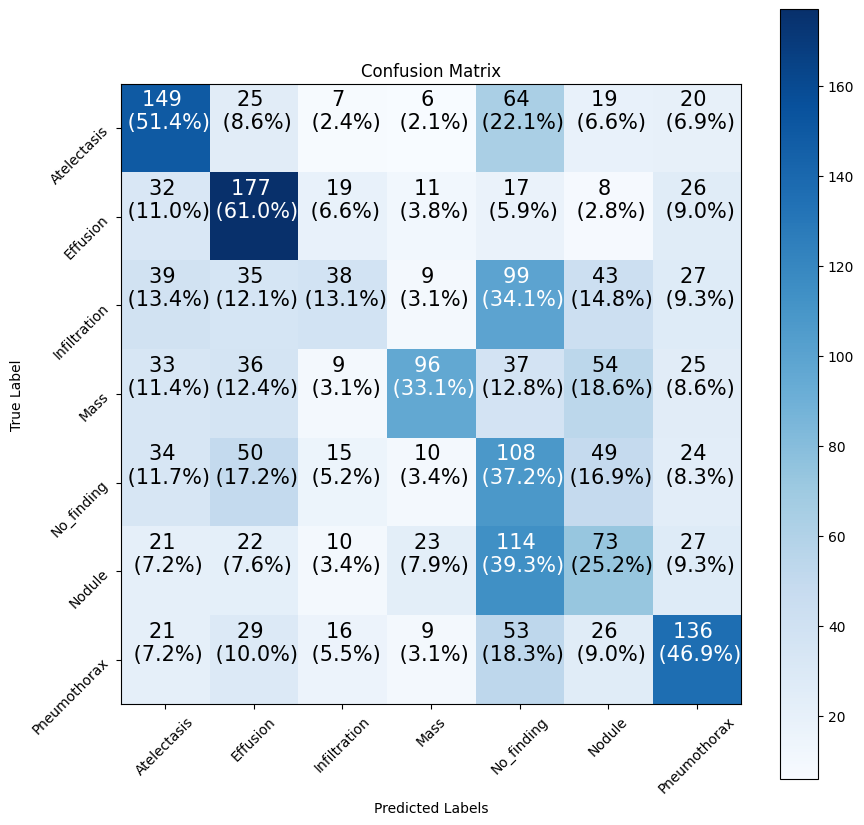

In [12]:
plot_confusion_matrix(test_labels, test_predictions, class_names)

This model performs well in predicting effusions, atelectasis and pneumothorax, but lacks accuracy when it comes to infiltrations. 
Infiltrations and nodules are often confused with no finding.

# Wrong predictions

In [30]:
img_names = []
for directory in class_names:
    for img in os.listdir(test_dir + "\\" + directory):
        img_names.append(img)

In [31]:
results_dict = {
                'label': test_labels, # use test labels as 'label
                'correct_label': [class_names[i] for i in test_labels], 
                'Prediction': [class_names[i] for i in test_predictions], 
                'Correct': [class_names[i] == class_names[j] for i, j in zip(test_labels, test_predictions)],
                'pred_prob': [max(i) for i in test_pred_probs],
                'img_name': img_names
                }
results_df = pd.DataFrame(results_dict)
results_df.head()

,label,correct_label,Prediction,Correct,pred_prob,img_name
0,0,Atelectasis,Atelectasis,True,0.763315,00000011_006.png
1,0,Atelectasis,Atelectasis,True,0.648332,00000030_000.png
2,0,Atelectasis,Atelectasis,True,0.499007,00000030_001.png
3,0,Atelectasis,Effusion,False,0.724232,00000032_054.png
4,0,Atelectasis,Atelectasis,True,0.654116,00000047_003.png


In [32]:
wrong_results_df = results_df[results_df['Correct'] == False].sort_values(['pred_prob'], ascending=False)
wrong_results_df.head(10)

,label,correct_label,Prediction,Correct,pred_prob,img_name
1545,5,Nodule,No_finding,False,0.976933,00001154_003.png
71,0,Atelectasis,No_finding,False,0.976796,00000451_000.png
1492,5,Nodule,No_finding,False,0.976788,00000556_000.png
696,2,Infiltration,No_finding,False,0.975272,00000422_007.png
1590,5,Nodule,No_finding,False,0.971529,00001836_100.png
247,0,Atelectasis,No_finding,False,0.971493,00001836_099.png
724,2,Infiltration,No_finding,False,0.970466,00000478_000.png
734,2,Infiltration,No_finding,False,0.970463,00000494_000.png
178,0,Atelectasis,No_finding,False,0.967505,00001220_000.png
1601,5,Nodule,Pneumothorax,False,0.967239,00001974_011.png


## Visualizing most wrong predictions

In [16]:
def find_image(img_name):
    for directory in os.listdir(test_dir):
        if img_name in os.listdir(test_dir + "\\" + directory):
            img = cv2.imread(test_dir + "\\" + directory + "\\" + img_name)
            return img

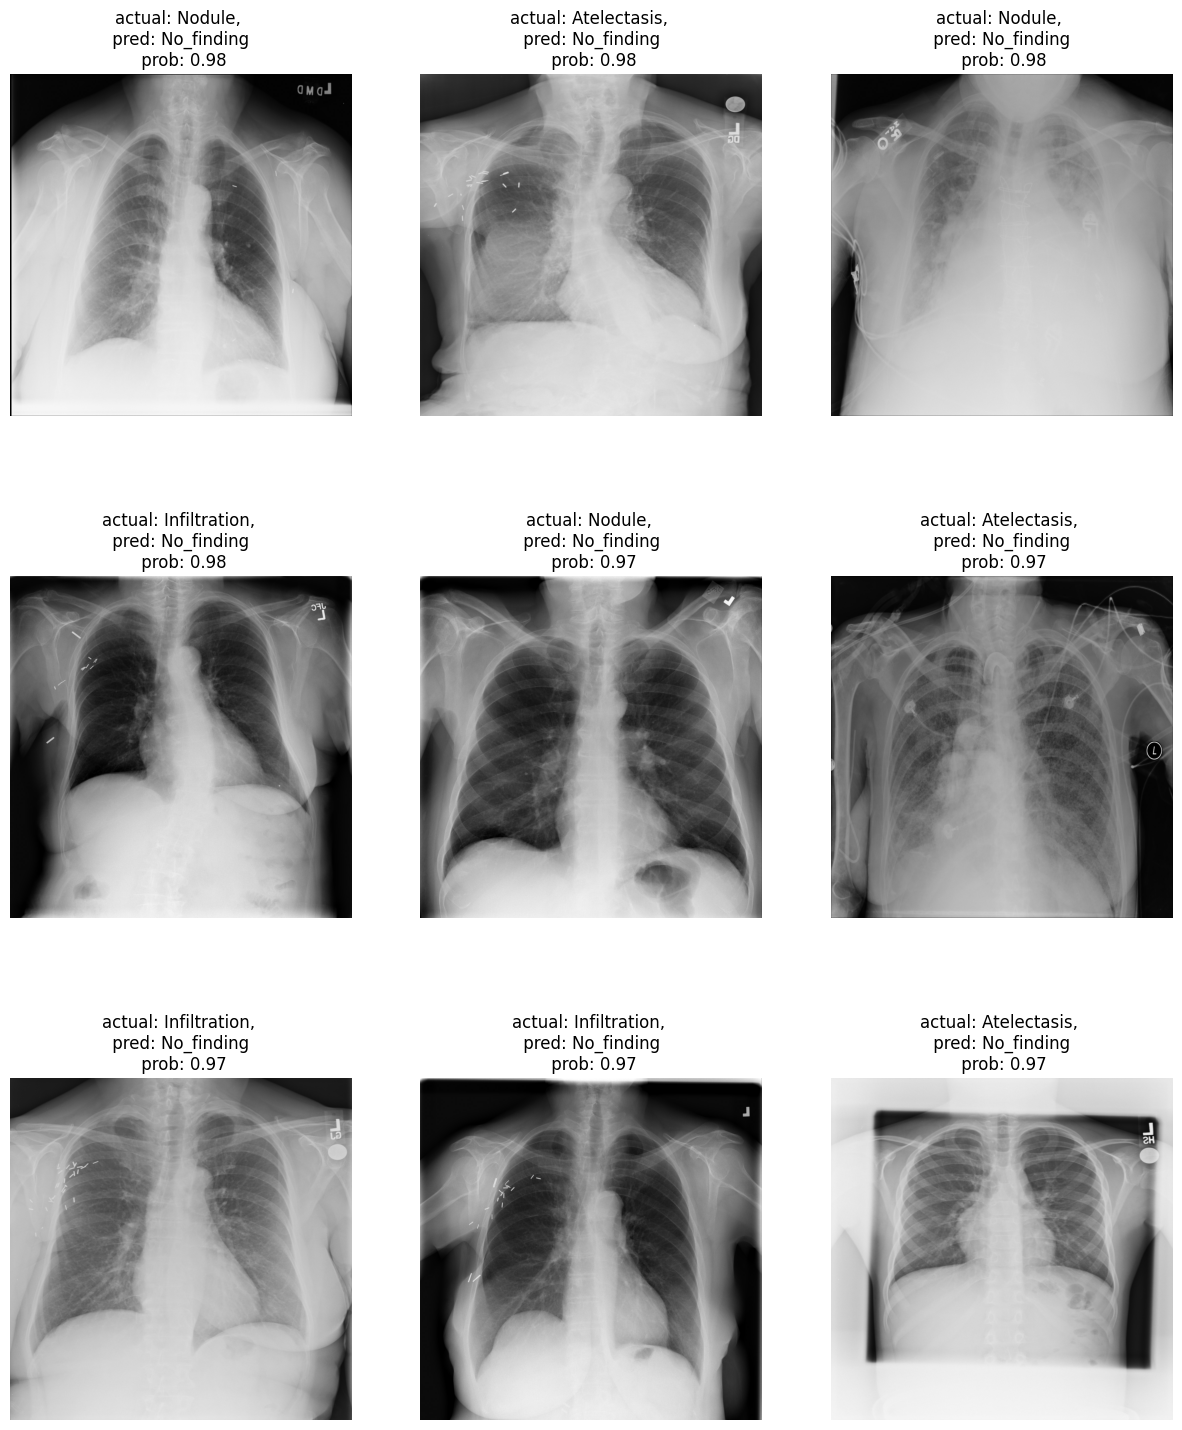

In [17]:
#Visualize some of the most wrong examples
images_to_view = 9
start_index = 0 # change the start index to view more
plt.figure(figsize=(15, 25))
for i, row in enumerate(wrong_results_df[start_index:start_index+images_to_view].itertuples()):
    plt.subplot(4, 3, i+1)
    _,_, label, prediction, _, pred_prob, img_name = row # only interested in a few parameters of each row
    img = find_image(img_name)
    plt.imshow(img/255.)
    plt.title(f"actual: {label}, \n pred: {prediction} \n prob: {pred_prob:.2f}")
    plt.axis(False)
